
# Classification de Genre avec CNN

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -qq "/content/drive/MyDrive/UTKFace.zip" -d "/content/UTKFace"

In [3]:
#Importation des bibliothèques
#Bibliothèques standards
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2

#TensorFlow & Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,
    Input, RandomFlip, RandomRotation, RandomZoom
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, accuracy_score, mean_absolute_error
)


In [ ]:
DATA_DIR = "/content/UTKFace/UTKFace"

In [ ]:
#Redimensionnement
IMG_HEIGHT = 64
IMG_WIDTH = 64

## Visualisation de la répartition des sexes

Avant de construire un modèle de classification basé sur un réseau de neurones convolutifs (CNN), nous analysons la répartition des données.

Cette étape permet de vérifier si le dataset est équilibré entre les classes, ici les genres "Homme" et "Femme".

Un déséquilibre dans les données pourrait entraîner un biais dans l’apprentissage du modèle, qui risquerait alors de mieux reconnaître la classe majoritaire au détriment de l’autre.

Une visualisation sous forme d’histogramme permet donc d’identifier d’éventuelles disparités et d’envisager solutions comme l’augmentation des données ou la pondération des classes dans la fonction de perte.

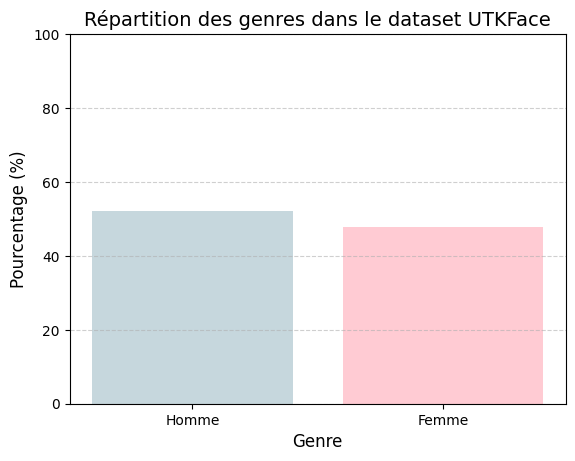

In [ ]:
# Le format des images est nommé de la manière suivante : "age_sexe_ethnie_dateNaiss.jpg"

file_names = os.listdir(DATA_DIR)
sex_labels = []
for file in file_names:
    parts = file.split('_')
    if len(parts) > 1:  # Vérifie que le format est correct
        sex_labels.append(int(parts[1]))  # Le deuxième élément est le sexe (0 = Homme, 1 = Femme)

# Compter les occurrences pour chaque sexe
labels, counts = np.unique(sex_labels, return_counts=True)

# Convertir les occurrences en pourcentages
percentages = (counts / counts.sum()) * 100

# Noms des classes
class_names = ["Homme", "Femme"]

# Visualisation en graphique à barres
plt.bar(class_names, percentages, color=['#AEC6CF', '#FFB6C1'], alpha=0.7)
plt.title("Répartition des genres dans le dataset UTKFace", fontsize=14)
plt.ylabel("Pourcentage (%)", fontsize=12)
plt.xlabel("Genre", fontsize=12)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


L’histogramme montre que le dataset UTKFace contient une légère dominance des images associées à la classe "Homme" par rapport à la classe "Femme" (environ 55% contre 45%).

Bien que cet écart ne soit pas extrêmement marqué, il peut influencer la performance du modèle si celui-ci tend à privilégier la classe majoritaire.

Une attention particulière sera donc portée à l’évaluation des métriques de performance (précision, rappel, F1-score) afin de s’assurer que le modèle ne favorise pas une classe au détriment de l’autre.

## Traitement des images d'UTKFace

Avant d'entraîner notre modèle CNN, nous prétraitons les images.

Le code ci-dessus effectue plusieurs étapes pour charger, nettoyer et préparer les images du dataset UTKFace:

In [ ]:
#TRAITEMENT DE L'IMAGE

def load_data(data_dir=DATA_DIR):
    X = [] #liste d'img après traitement convertit en NumPY
    y = [] #liste contenant les genres

    # Récup tts les img dans UTKFace
    file_names = os.listdir(data_dir)

    for file in file_names:
        # nom de fichier type "age_sexe_ethnie_dateNaiss.jpg"
        # On récupère le deuxième champ pour le genre
        # 0 => Homme, 1 => Femme
        parts = file.split("_")
        gender_str = parts[1]
        try:
            gender = int(gender_str)
        except:
            continue

        # lecture
        img_path = os.path.join(data_dir, file)
        img = cv2.imread(img_path)
        if img is None:
            continue

        # conversion en RGB (cv2 lit en BGR par défaut)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # redimension
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

        # Normalisation
        img = img.astype("float32") / 255.0

        X.append(img)
        y.append(gender)

    return np.array(X), np.array(y)


Tout d'abord, nous récupérons la liste des fichiers images présents dans le dossier contenant le dataset.

Chaque fichier suit un format de nommage standard : "age_sexe_ethnie_dateNaiss.jpg", où la deuxième valeur représente le genre (0 pour homme, 1 pour femme).

Nous extrayons cette valeur pour créer notre vecteur ```y```, qui servira de labels pour la classification.

Ensuite, chaque image est chargée:
 ```(cv2.imread())```.

Par défaut, OpenCV charge les images en format BGR, nous les convertissons donc en RGB : ```(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))```.

Une fois convertie, l’image est redimensionnée ```(cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT)))``` à une taille définie (64x64 pixels dans notre cas).

Enfin, nous normalisons les valeurs des pixels en les divisant par 255 : ```(img.astype("float32") / 255.0)```, ce qui permet d'avoir des valeurs comprises entre 0 et 1.

Les images traitées sont stockées dans un tableau  ```X```, et les labels correspondants dans ```y```.

In [ ]:
# Chargement des données
X, y = load_data(DATA_DIR)

print("Nombre d'images chargées :", len(X))
print("Dimension de X :", X.shape)
print("Dimension de y :", y.shape)

Nombre d'images chargées : 23708
Dimension de X : (23708, 64, 64, 3)
Dimension de y : (23708,)


Le chargement et le prétraitement ont permis d’obtenir 23 708 images, toutes converties au format RGB, redimensionnées et normalisées.

Les dimensions finales des tableaux de données sont :

```X.shape``` : (23708, 64, 64, 3), indiquant que nous avons 23 708 images de taille 64x64 avec 3 canaux de couleurs (RGB).

```y.shape``` : (23708,), représentant le vecteur des labels associés à chaque image.

## Division du jeu de données

Pour évaluer correctement la capacité de généralisation d’un modèle, nous séparons les données en plusieurs sous-ensembles :

- **Jeu d’entraînement (train) 64%** : Est la partie la plus importante car c'est là où le modèle apprend. Plus il y a de données, mieux il pourra généraliser.

 On pourrait vouloir 80-90% pour l'entraînement, mais cela signifie moins de données pour la validation.

 Or, sans validation, on ne pourrait pas mesurer correctement si le modèle est en train de sur-apprendre (overfitting).


- **Jeu de validation (val) 20%** : Permet d’affiner les hyperparamètres (nombre d’époques, taux d’apprentissage, etc.) et de détecter le surapprentissage (overfitting).  
Si on met trop peu (ex. 5-10%), les ajustements risquent d’être moins précis.

 Si on met trop (ex. 30-40%), il reste trop peu de données pour entraîner le modèle.


- **Jeu de test (test) 20%** : Utilisé uniquement pour évaluer les performances finales du modèle sur des données qu’il n’a jamais vues. Il sert à estimer comment le modèle se comportera sur des nouvelles images dans un contexte réel/

 Si on prend trop peu de données en test (<10%), la mesure de performance sera peu fiable.

 Si on prend trop de données en test (>30%), on réduit trop l’ensemble d'entraînement et le modèle risque d’apprendre moins bien.

In [ ]:
#DIVISER LE JEU DE DONN2ES :

# 1. Jeu d'entraînement (X_train, y_train) : utilisé pour entraîner le modèle.
    #Jeu de test (X_test, y_test) : utilisé pour évaluer les performances du modèle sur des données qu'il n'a jamais vues.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,    # 20% pour le jeu de test
    stratify=y         # Proportions de classes respectées
)

# 2. Séparer l'entraînement en sous-ensemble d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,  # 10% de l'entraînement pour la validation
    stratify=y_train
)

print("Taille du jeu d'entraînement :", X_train.shape, len(y_train))
print("Taille du jeu de test :", X_test.shape, len(y_test))

Taille du jeu d'entraînement : (15172, 64, 64, 3) 15172
Taille du jeu de test : (4742, 64, 64, 3) 4742


## I. Première Observation : Implémentation d'un Modèle Simple

Avant d'élaborer un grand modèle, nous commencerons par une première expérimentation avec une architecture simple.

L'objectif ici est d'obtenir une première estimation de la performance d'un CNN minimaliste sur la classification de genre avec le dataset UTKFace.

Cette approche permet d'identifier les améliorations pour les prochaines versions du modèle.

### Implémentation 1

In [ ]:
# PREMIER ESSAI : OBSERVATION

def build_model_v1(input_shape=(64, 64, 3)):
    model = Sequential([
        Input(shape=input_shape),                 # Entrée du réseau (images 64 x 64 en RGB)

        Conv2D(16, (3, 3), activation='relu'),    # Convolution: 16 filtres, kernel 3x3, activation ReLU
        MaxPooling2D((2, 2)),                     # MaxPooling: réduit la dimension spatiale de moitié (64→32)

        Flatten(),                                # Aplatissement pour passer de la partie "convolutive" à la partie "dense"

        Dense(16, activation='relu'),             # Couche fully-connected (dense) avec 16 neurones
        Dense(1, activation='sigmoid')            # Couche de sortie: 1 neurone pour la classification binaire (Homme/Femme)
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),      # Optimiseur Adam, taux d'apprentissage de 0.001
        loss='binary_crossentropy',               # Fonction de perte adaptée à un problème de classification binaire
        metrics=['accuracy']                      # Métrique principale: accuracy
    )
    return model


model_v1 = build_model_v1((64, 64, 3))
model_v1.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 15376)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │         246,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 246,497 (962.88 KB)

 Trainable params: 246,497 (962.88 KB)

 Non-trainable params: 0 (0.00 B)

Le modèle V1 a été conçu avec une architecture volontairement simple, utilisant peu de paramètres, afin de tester si une structure minimale permet déjà d’extraire suffisamment d’informations pour réaliser la classification.

1. Choix de la taille des images (64x64x3) :
  - Les images ont été réduites à 64x64 pixels avec 3 canaux (RGB).
  Une taille plus grande (~128x128 ou 256x256) aurait offert plus de détails, mais l’objectif étant de détecter des caractéristiques globales du visage (formes, structures), une résolution modérée suffit pour un premier test.

2. Couche Flatten() :
  - Le Flatten est essentiel pour transformer les sorties 2D de la convolution en un vecteur 1D, qui pourra être utilisé par les couches denses suivantes.

3. Couche de sortie Dense(1, activation='sigmoid') :
  - Un seul neurone en sortie, car il s’agit d’une classification binaire (homme ou femme).
  - L’activation sigmoïde  est choisie car elle permet de produire une probabilité entre 0 et 1, ce qui est adapté aux problèmes de classification binaire.


In [ ]:
history_v1 = model_v1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.7249 - loss: 0.5249 - val_accuracy: 0.8653 - val_loss: 0.3415
Epoch 2/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - accuracy: 0.8599 - loss: 0.3291 - val_accuracy: 0.8846 - val_loss: 0.2966
Epoch 3/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.8799 - loss: 0.2867 - val_accuracy: 0.8851 - val_loss: 0.2721
Epoch 4/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - accuracy: 0.8858 - loss: 0.2689 - val_accuracy: 0.8856 - val_loss: 0.2709
Epoch 5/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.8937 - loss: 0.2509 - val_accuracy: 0.8880 - val_loss: 0.2716
Epoch 6/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.9046 - loss: 0.2336 - val_accuracy: 0.8888 - val_loss: 0.2780
Epoch 7/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - accuracy: 0.9060 - loss: 0.2246 - val_accuracy: 0.8914 - val_loss: 0.2656
Epoch 8/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 23s 41ms/step - accuracy: 0.9135 - loss: 0.2146 - 

### Analyse des métriques

In [ ]:
# Évaluation sur le jeu de test

test_loss_v1, test_acc_v1 = model_v1.evaluate(X_test, y_test, verbose=0)
print(f"[V1] Test accuracy: {test_acc_v1:.4f}")

# Prédictions sur le jeu de test
y_pred_prob_v1 = model_v1.predict(X_test)
y_pred_v1 = (y_pred_prob_v1 > 0.5).astype("int32")

# Rapport de classification pour le jeu de test
print(classification_report(y_test, y_pred_v1, target_names=["Homme", "Femme"]))

[V1] Test accuracy: 0.8764
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
              precision    recall  f1-score   support

       Homme       0.86      0.92      0.89      2478
       Femme       0.90      0.83      0.87      2264

    accuracy                           0.88      4742
   macro avg       0.88      0.87      0.88      4742
weighted avg       0.88      0.88      0.88      4742



 **Métriques sur le jeu de test :**


L’accuracy globale de 87.64 % indique que le modèle fait des prédictions correctes dans la majorité des cas.

Le modèle détecte mieux les hommes que les femmes (rappel 0.92 vs 0.83).

Cela signifie qu’il a tendance à classer certaines femmes à tort comme des hommes.

La précision est légèrement meilleure pour la classe "Femme" (0.90 contre 0.86 pour "Homme"), ce qui signifie que lorsqu'il prédit "Femme", il a généralement raison.


L’écart entre le rappel des deux classes montre que le modèle a un biais, possiblement dû à un déséquilibre dans les données ou à une difficulté du modèle à extraire des caractéristiques discriminantes pour la classe "Femme".

In [ ]:
# Évaluation sur le jeu de validation
test_loss_val, test_acc_val = model_v1.evaluate(X_val, y_val, verbose=0)
print(f"[V1] Validation accuracy: {test_acc_val:.4f}")

# Prédictions sur le jeu de validation
y_pred_prob_val = model_v1.predict(X_val)
y_pred_val = (y_pred_prob_val > 0.5).astype("int32")

# Rapport de classification pour le jeu de validation
print(classification_report(y_val, y_pred_val, target_names=["Homme", "Femme"]))

Validation accuracy: 0.8896
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
              precision    recall  f1-score   support

       Homme       0.87      0.93      0.90      1983
       Femme       0.91      0.85      0.88      1811

    accuracy                           0.89      3794
   macro avg       0.89      0.89      0.89      3794
weighted avg       0.89      0.89      0.89      3794



 **Métriques sur le jeu de validation :**


L’accuracy sur la validation (88.96%) est légèrement supérieure à celle du test (87.64%), ce qui peut indiquer que le modèle s’adapte légèrement trop aux données de validation et perd en généralisation.

On retrouve le même déséquilibre dans le rappel des classes : le modèle détecte mieux les hommes que les femmes.

Le score F1 est équilibré, ce qui indique que les erreurs restent raisonnablement réparties malgré le léger biais observé.

### Visualisations de la courbe de la fonction de perte et de l'accuracy

Les courbes obtenues après l’entraînement du modèle V1 permettent d’évaluer la progression de l’apprentissage et d’identifier d’éventuels problèmes liés à la convergence du modèle ou à sa capacité de généralisation.

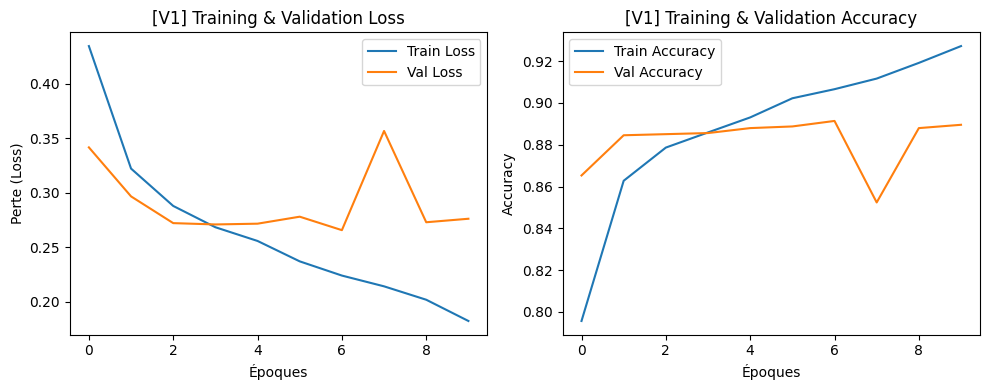

In [ ]:
plt.figure(figsize=(10,4))

# Courbe de la fonction de perte (Loss)
plt.subplot(1,2,1)
plt.plot(history_v1.history['loss'], label='Train Loss')
plt.plot(history_v1.history['val_loss'], label='Val Loss')
plt.xlabel('Époques')
plt.ylabel('Perte (Loss)')
plt.legend()
plt.title('[V1] Training & Validation Loss')

# Courbe de l’Accuracy
plt.subplot(1,2,2)
plt.plot(history_v1.history['accuracy'], label='Train Accuracy')
plt.plot(history_v1.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Époques')
plt.ylabel('Accuracy')
plt.legend()
plt.title('[V1] Training & Validation Accuracy')

plt.tight_layout()
plt.show()

- Analyse de la fonction de perte (Loss) :
La loss d’entraînement diminue de manière régulière, ce qui montre que le modèle apprend bien sur ses données d’entraînement.
La loss de validation suit une tendance générale de diminution mais présente des fluctuations visibles, notamment une remontée après l’époque 5.

Cette remontée indique que le modèle commence à sur-apprendre, c'est-à-dire qu'il s’adapte trop aux données d’entraînement et ne généralise plus aussi bien sur des données nouvelles.
Vers la fin de l'entraînement, la validation loss ne diminue plus et reste instable, confirmant un début de surapprentissage.

- Analyse de la précision (Accuracy) :
L’accuracy en entraînement augmente continuellement, atteignant plus de 92 % en fin d'entraînement.
L’accuracy en validation suit également une progression, mais elle stagne autour de 88-89 % après plusieurs époques.

Un écart se creuse entre les deux courbes, ce qui est un indicateur que le modèle généralise moins bien sur les données de validation.
Les fluctuations de la validation accuracy montrent que le modèle ne s'améliore plus après un certain point, renforçant l’hypothèse du surapprentissage.

Le modèle est performant sur l'entraînement, mais perd en généralisation après quelques époques.
L’instabilité de la validation loss et de la validation accuracy suggère que le modèle pourrait bénéficier de régularisation pour éviter qu’il ne s’adapte trop aux données d’entraînement.
La validation accuracy n’évolue plus après un certain point, ce qui signifie qu’un arrêt anticipé (early stopping) pourrait être pertinent pour éviter d’entraîner inutilement le modèle sur des époques supplémentaires.


### Améliorations possibles dans la version suivante  

De ce fait, nous pourrions améliorer notre modèle en :

- Ajoutant plus de couches convolutionnelles pour détecter plujs de motifs.
Augmenter le nombre de filtres dans chaque couche pour capturer plus d’informations.

- Ajoutant un Dropout dans les couches denses pour éviter que le réseau ne mémorise trop les données d’entraînement.

- Utilisant la Batch Normalization, qui stabilise l'apprentissage et limite les fluctuations de la validation loss.

- Ajoutant un Early Stopping pour stopper l'entraînement si la validation loss ne s'améliore plus après plusieurs époques.

- Réduire le learning rate si nécessaire pour permettre un apprentissage plus progressif et éviter les oscillations de la validation loss.

- Appliquant du data augmentation pour générer plus de diversité dans les images et éviter que le modèle ne s’adapte trop fortement aux données d'entraînement.

## II. Second essai : Amélioration du premier modèle

L'implémentation du modèle V2 repose sur l’analyse des résultats obtenus avec V1.

### Implémentation 2

In [ ]:
# Définition du modèle
def build_model_v2(input_shape=(64, 64, 3)):
    model = Sequential([
        # Data Augmentation
        Input(shape=input_shape),
        RandomFlip("horizontal"),
        RandomRotation(0.1),
        RandomZoom(0.1),

        # Bloc 1
        Conv2D(16, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Bloc 2
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Bloc 3
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Bloc 4
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),

        # Couche Dense + Dropout
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),

        # Sortie binaire (Homme/Femme)
        Dense(1, activation='sigmoid')
    ])

    # Compilation
    model.compile(
        optimizer=Adam(learning_rate=0.001),  # LR initial
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


model_v2 = build_model_v2((64, 64, 3))
model_v2.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_3 (RandomFlip)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_3 (RandomRotation)   │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_3 (RandomZoom)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 64, 64, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 64, 64, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │              

 Total params: 361,313 (1.38 MB)

 Trainable params: 360,577 (1.38 MB)

 Non-trainable params: 736 (2.88 KB)

- Contrairement à V1, V2 introduit une phase de prétraitement des images directement dans le modèle avec des transformations aléatoires :
  - RandomFlip("horizontal") : Simule des variations en retournant aléatoirement les images.
  - RandomRotation(0.1) : Permet de simuler des légères rotations des visages.
  - RandomZoom(0.1) : Introduit des zooms aléatoires.

- Le modèle V2 introduit plus de couches convolutives et plus de filtres que le modèle V1 :
  - V1 utilisait une seule couche de convolution avec 16 filtres.
  - V2 applique quatre blocs convolutifs successifs, avec un nombre croissant de filtres (16 → 32 → 64 → 128).

- Chaque bloc convolutionnel est maintenant suivi d’une normalisation de batch, ce qui :
  - Stabilise l’apprentissage
  - Accélère la convergence et permet d’utiliser un taux d’apprentissage plus élevé sans risque d’explosions de gradient.

- Renforcement de la régularisation avec Dropout (Dropout(0.4)) :
  - Contrairement à V1, V2 inclut une couche de Dropout après la couche dense pour éviter que le modèle ne mémorise trop les données d'entraînement.
  
  0.4 signifie que 40 % des neurones sont désactivés aléatoirement à chaque passage, renforçant ainsi la généralisation du modèle.

- Augmentation du nombre de neurones dans la couche dense (128)

In [ ]:
# Callbacks: EarlyStopping + ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Surveille la val_loss
    factor=0.5,          # Divise le LR par 2
    patience=3,          # Après 3 époques sans amélioration
    min_lr=1e-5          # LR plancher
)


history_v2 = model_v2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,          # Nombre max d'époques
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 74s 148ms/step - accuracy: 0.6921 - loss: 0.6470 - val_accuracy: 0.6447 - val_loss: 0.6273 - learning_rate: 0.0010
Epoch 2/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 69s 146ms/step - accuracy: 0.8066 - loss: 0.4223 - val_accuracy: 0.8179 - val_loss: 0.4219 - learning_rate: 0.0010
Epoch 3/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 82s 145ms/step - accuracy: 0.8320 - loss: 0.3718 - val_accuracy: 0.8759 - val_loss: 0.2910 - learning_rate: 0.0010
Epoch 4/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 79s 140ms/step - accuracy: 0.8534 - loss: 0.3297 - val_accuracy: 0.8300 - val_loss: 0.3705 - learning_rate: 0.0010
Epoch 5/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 83s 143ms/step - accuracy: 0.8611 - loss: 0.3148 - val_accuracy: 0.8824 - val_loss: 0.2767 - learning_rate: 0.0010
Epoch 6/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 82s 144ms/step - accuracy: 0.8540 - loss: 0.3196 - val_accuracy: 0.8875 - val_loss: 0.2668 - learning_rate: 0.0010
Epoch 7/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 81s 143ms/step - accuracy: 0.8

### Analyse des métriques

In [ ]:
# Évaluation sur le jeu de test
test_loss_v2, test_acc_v2 = model_v2.evaluate(X_test, y_test, verbose=0)
print(f"[V2] Test accuracy: {test_acc_v2:.4f}")

# Prédictions sur le jeu de test
y_pred_prob_v2 = model_v2.predict(X_test)
y_pred_v2 = (y_pred_prob_v2 > 0.5).astype("int32")

# Rapport de classification pour le jeu de test
print(classification_report(y_test, y_pred_v2, target_names=["Homme", "Femme"]))

[V2] Test accuracy: 0.9142
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step
              precision    recall  f1-score   support

       Homme       0.92      0.92      0.92      2478
       Femme       0.91      0.91      0.91      2264

    accuracy                           0.91      4742
   macro avg       0.91      0.91      0.91      4742
weighted avg       0.91      0.91      0.91      4742



L’accuracy du test est passée de 87.64 % (V1) à 91.42 % (V2), soit une amélioration de près de 4 %. L’accuracy en validation suit également cette progression, montrant que le modèle V2 généralise mieux que V1.

L’augmentation du nombre de couches et l’utilisation de Batch Normalization semblent avoir stabilisé l’apprentissage, tandis que l’ajout de Dropout et de l’Early Stopping a permis de limiter le surapprentissage.

In [ ]:
# Évaluation sur le jeu de validation
test_loss_val, test_acc_val = model_v2.evaluate(X_val, y_val, verbose=0)
print(f"[V2] Validation accuracy: {test_acc_val:.4f}")

# Prédictions sur le jeu de validation
y_pred_prob_val = model_v2.predict(X_val)
y_pred_val = (y_pred_prob_val > 0.5).astype("int32")

# Rapport de classification pour le jeu de validation
print(classification_report(y_val, y_pred_val, target_names=["Homme", "Femme"]))

[V2] Validation accuracy: 0.9125
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step
              precision    recall  f1-score   support

       Homme       0.92      0.91      0.92      1983
       Femme       0.91      0.91      0.91      1811

    accuracy                           0.91      3794
   macro avg       0.91      0.91      0.91      3794
weighted avg       0.91      0.91      0.91      3794



Contrairement à V1, où l’équilibre entre les classes était légèrement biaisé en faveur des hommes, V2 montre des scores parfaitement équilibrés entre les classes "Homme" et "Femme".

Le rappel de la classe "Femme" est passé de 0.84 (V1) à 0.91 (V2), réduisant ainsi les erreurs de classification.

La précision des deux classes est maintenant symétrique (0.91-0.92), ce qui signifie que le modèle fait aussi bien pour identifier un homme qu’une femme.



### Visualisations de la courbe de la fonction de perte et de l'accuracy

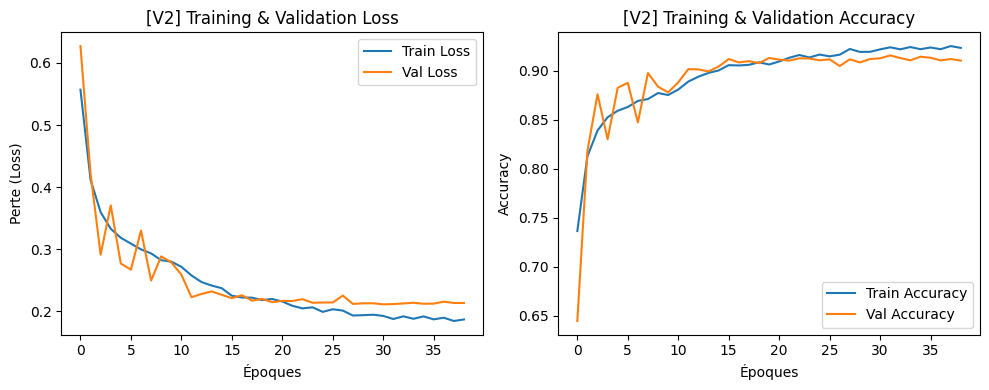

In [ ]:
plt.figure(figsize=(10,4))

# Courbe de la fonction de perte
plt.subplot(1,2,1)
plt.plot(history_v2.history['loss'], label='Train Loss')
plt.plot(history_v2.history['val_loss'], label='Val Loss')
plt.xlabel('Époques')
plt.ylabel('Perte (Loss)')
plt.legend()
plt.title('[V2] Training & Validation Loss')

# Courbe d’accuracy
plt.subplot(1,2,2)
plt.plot(history_v2.history['accuracy'], label='Train Accuracy')
plt.plot(history_v2.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Époques')
plt.ylabel('Accuracy')
plt.legend()
plt.title('[V2] Training & Validation Accuracy')

plt.tight_layout()
plt.show()

La loss d’entraînement diminue progressivement, sans oscillations excessives.

La loss de validation suit une tendance similaire et ne montre pas de remontée brutale, ce qui signifie que le modèle ne semble pas souffrir de surajustement.

Dans V1, la validation loss commençait à osciller après quelques époques, ce qui était un signe de surapprentissage.

Ici, V2 reste plus stable, ce qui confirme une meilleure régularisation.


L’accuracy d’entraînement et de validation sont très proches, signe que le modèle généralise bien sans apprendre excessivement les données d’entraînement.

L’accuracy de validation dépasse légèrement celle de l’entraînement à certaines époques, ce qui peut être dû aux effets du Dropout et de la régularisation, qui rendent le modèle plus robuste sur des données non vues.

## III. Adaptation du Modèle à une Résolution de 128×128

Dans le cadre d'une potentielle amélioration du modèle, nous avons testé un redimensionnement des images en 128×128 au lieu de 64×64.

L’objectif est d’exploiter plus d’informations visuelles pour améliorer la classification, au prix d’un coût computationnel plus élevé.

Cependant, une limitation mémoire (RAM insuffisante) a empêché d’appliquer directement ce changement avec l’implémentation initiale.

En effet, dans l’implémentation précédente, les images étaient chargées et stockées en mémoire sous forme de tableaux NumPy avant d’être traitées.

Or, stocker des images en 128×128×3 nécessite quatre fois plus de mémoire qu’avec des images de 64×64×3.

De ce fait, lorsque le dataset contient plusieurs dizaines de milliers d’images, la consommation mémoire explose, rendant l’entraînement impossible sur une machine avec une RAM limitée.


Pour contourner cette contrainte, au lieu de charger toutes les images en RAM, la solution mise en place consiste à :

  - Stocker uniquement les chemins des fichiers, sans charger directement les images.

  - Créer un dataset TensorFlow (tf.data.Dataset), qui charge les images à la demande, directement depuis le stockage.

  - Appliquer le prétraitement à la volée, au lieu de stocker des images redimensionnées.

  - Utiliser le prefetching et le batching, afin d’optimiser la rapidité du pipeline.



In [ ]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32
TEST_SIZE = 0.2
VAL_SIZE = 0.2

### Prétraitement des images et chargement des fichiers

In [ ]:
# --- PRÉTRAITEMENT D'UNE IMAGE ---
def preprocess_image(image_path, label):
    """
    Charge une image, la redimensionne, et la normalise.
    """
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))  # Resize en 128*128
    image = image / 255.0  # Normalisation entre [0,1]
    return image, label

In [ ]:
# --- CHARGEMENT DES FICHIERS ---
file_paths = []
labels = []

for file in os.listdir(DATA_DIR):
    parts = file.split("_")
    if len(parts) < 2:
        continue  # Évite les fichiers mal nommés

    try:
        gender = int(parts[1])  # Récupère le genre (0 = Homme, 1 = Femme)
    except:
        continue  # Ignore les erreurs

    file_paths.append(os.path.join(DATA_DIR, file))
    labels.append(gender)

file_paths = np.array(file_paths)
labels = np.array(labels)

print(f"Nombre total d'images : {len(file_paths)}")


Nombre total d'images : 23708


### Division du jeu de données

In [ ]:
# --- SPLIT TRAIN / TEST / VALIDATION ---
X_train, X_test, y_train, y_test = train_test_split(
    file_paths, labels,
    test_size=TEST_SIZE,
    stratify=labels,
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=VAL_SIZE,
    stratify=y_train,
    random_state=42
)

print(f"Taille du jeu d'entraînement : {len(X_train)}")
print(f"Taille du jeu de validation : {len(X_val)}")
print(f"Taille du jeu de test : {len(X_test)}")


Taille du jeu d'entraînement : 15172
Taille du jeu de validation : 3794
Taille du jeu de test : 4742


### Création des datasets tf

In [ ]:
# --- CRÉATION DES DATASETS TF ---
def create_tf_dataset(X, y, batch_size=BATCH_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = create_tf_dataset(X_train, y_train)
val_dataset = create_tf_dataset(X_val, y_val)
test_dataset = create_tf_dataset(X_test, y_test)


### Implémentation 3

In [ ]:
def build_model_v3(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)):
    model = Sequential([
        # Data Augmentation
        Input(shape=input_shape),
        RandomFlip("horizontal"),
        RandomRotation(0.1),
        RandomZoom(0.1),

        # Bloc 1
        Conv2D(16, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Bloc 2
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Bloc 3
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Bloc 4
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Bloc 5
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),

        # Couche Dense + Dropout
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        # Sortie binaire (Homme/Femme)
        Dense(1, activation='sigmoid')
    ])

    # Compilation
    model.compile(
        optimizer=Adam(learning_rate=0.001),  # LR initial
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

model_v3 = build_model_v3((IMG_HEIGHT, IMG_WIDTH, 3))
model_v3.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_5 (RandomFlip)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_5 (RandomRotation)   │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_5 (RandomZoom)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 128, 128, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 128, 128, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 4096)                │              

 Total params: 1,444,705 (5.51 MB)

 Trainable params: 1,443,201 (5.51 MB)

 Non-trainable params: 1,504 (5.88 KB)

In [ ]:
# --- CALLBACKS ---
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-5
)

# --- ENTRAÎNEMENT ---
history_v3 = model_v3.fit(
    train_dataset,                # On utilise tf.data.Dataset
    validation_data=val_dataset,  # Dataset de validation
    epochs=50,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 378s 787ms/step - accuracy: 0.7022 - loss: 0.6864 - val_accuracy: 0.7483 - val_loss: 0.5096 - learning_rate: 0.0010
Epoch 2/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 366s 770ms/step - accuracy: 0.7974 - loss: 0.4415 - val_accuracy: 0.8366 - val_loss: 0.3621 - learning_rate: 0.0010
Epoch 3/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 353s 709ms/step - accuracy: 0.8398 - loss: 0.3620 - val_accuracy: 0.8569 - val_loss: 0.3304 - learning_rate: 0.0010
Epoch 4/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 341s 718ms/step - accuracy: 0.8559 - loss: 0.3282 - val_accuracy: 0.8519 - val_loss: 0.3310 - learning_rate: 0.0010
Epoch 5/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 377s 707ms/step - accuracy: 0.8680 - loss: 0.3132 - val_accuracy: 0.8722 - val_loss: 0.2935 - learning_rate: 0.0010
Epoch 6/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 385s 715ms/step - accuracy: 0.8730 - loss: 0.2978 - val_accuracy: 0.8524 - val_loss: 0.3212 - learning_rate: 0.0010
Epoch 7/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 379s 707ms/step - accura

### Analyse des métriques

L’objectif de V3 était d'observer l’impact de l’augmentation de la résolution des images (128×128) et de la nouvelle méthode de gestion des images sur les performances du modèle.


Cette version est comparée à V2 (64×64) afin d’observer les éventuelles améliorations en termes de précision, de généralisation et de stabilité de l’apprentissage.

In [ ]:
# --- ÉVALUATION SUR LE TEST SET ---
test_loss_v3, test_acc_v3 = model_v3.evaluate(test_dataset, verbose=0)
print(f"[V3] Test accuracy: {test_acc_v3:.4f}")

# --- PRÉDICTIONS SUR LE TEST SET ---
y_pred_prob_v3 = model_v3.predict(test_dataset)
y_pred_v3 = (y_pred_prob_v3 > 0.5).astype("int32")

# Récupération des vraies étiquettes du test set
y_true_v3 = np.concatenate([y for _, y in test_dataset], axis=0)

# Rapport de classification pour le jeu de test
print(classification_report(y_true_v3, y_pred_v3, target_names=["Homme", "Femme"]))


[V3] Test accuracy: 0.9062
149/149 ━━━━━━━━━━━━━━━━━━━━ 22s 149ms/step
              precision    recall  f1-score   support

       Homme       0.92      0.90      0.91      2478
       Femme       0.89      0.91      0.90      2264

    accuracy                           0.91      4742
   macro avg       0.91      0.91      0.91      4742
weighted avg       0.91      0.91      0.91      4742



L’accuracy du test a légèrement diminué de 91.42 % (V2) à 90.62 % (V3), tandis que celle de validation a également baissé d’environ 1.2 %.

Contrairement aux attentes, l’augmentation de la résolution n’a pas entraîné d’amélioration notables des performances, ce qui suggère que

La résolution 64×64 capturait déjà suffisamment d’informations pour la classification, et la montée en 128×128 n’a pas ajouté de valeur discriminante.
La montée en résolution a augmenté la complexité du modèle, mais sans un gain clair en termes de généralisation.

In [ ]:
# --- ÉVALUATION SUR LE VALIDATION SET ---
val_loss_v3, val_acc_v3 = model_v3.evaluate(val_dataset, verbose=0)
print(f"[V3] Validation accuracy: {val_acc_v3:.4f}")

# --- PRÉDICTIONS SUR LE VALIDATION SET ---
y_pred_prob_val_v3 = model_v3.predict(val_dataset)
y_pred_val_v3 = (y_pred_prob_val_v3 > 0.5).astype("int32")

# Récupération des vraies étiquettes du validation set
y_true_val_v3 = np.concatenate([y for _, y in val_dataset], axis=0)

# Rapport de classification pour le jeu de validation
print(classification_report(y_true_val_v3, y_pred_val_v3, target_names=["Homme", "Femme"]))

[V3] Validation accuracy: 0.9006
119/119 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step
              precision    recall  f1-score   support

       Homme       0.92      0.89      0.90      1983
       Femme       0.88      0.91      0.90      1811

    accuracy                           0.90      3794
   macro avg       0.90      0.90      0.90      3794
weighted avg       0.90      0.90      0.90      3794



Les scores montrent une légère baisse du rappel pour la classe "Homme" dans V3 (de 0.92 à 0.90), tandis que la précision de la classe "Femme" diminue également légèrement (de 0.91 à 0.89).

Ces changements indiquent que le modèle V3, composé de couches et paramètres plus importants, a plus de difficultés à identifier correctement certaines classes par rapport à V2.

Il n'y a pas d'amélioration.


### Visualisations de la courbe de la fonction de perte et de l'accuracy

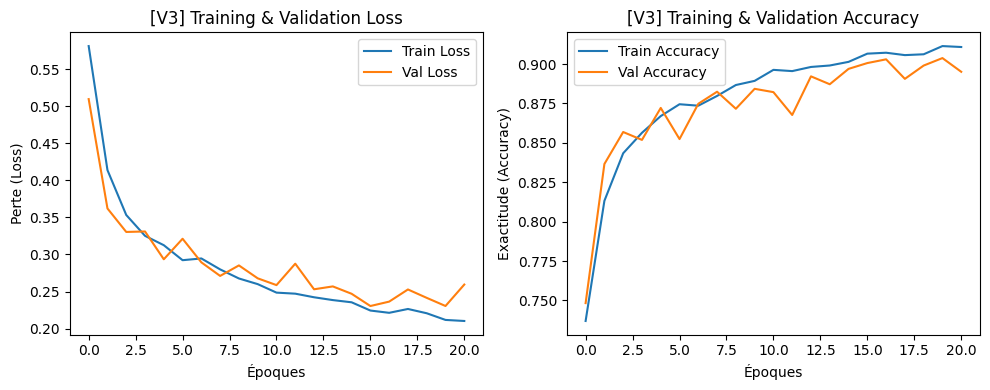

In [ ]:
plt.figure(figsize=(10,4))

# Courbe de la fonction de perte
plt.subplot(1,2,1)
plt.plot(history_v3.history['loss'], label='Train Loss')
plt.plot(history_v3.history['val_loss'], label='Val Loss')
plt.xlabel('Époques')
plt.ylabel('Perte (Loss)')
plt.legend()
plt.title('[V3] Training & Validation Loss')

# Courbe d’accuracy
plt.subplot(1,2,2)
plt.plot(history_v3.history['accuracy'], label='Train Accuracy')
plt.plot(history_v3.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Époques')
plt.ylabel('Exactitude (Accuracy)')
plt.legend()
plt.title('[V3] Training & Validation Accuracy')

plt.tight_layout()
plt.show()


Fonction de Perte (Loss)

La perte d’entraînement diminue de manière continue, indiquant un bon apprentissage.

La perte de validation montre plus de fluctuations, notamment vers la fin de l’entraînement, suggérant une moins bonne stabilité par rapport à V2.

Une légère remontée de la validation loss vers la fin pourrait indiquer un début de surapprentissage.

Précision (Accuracy)
L’accuracy d’entraînement et de validation suivent une trajectoire similaire, bien que l’accuracy de validation fluctue davantage que dans V2.

À partir de la 10ᵉ époque, l’accuracy de validation cesse de progresser, ce qui peut indiquer que le modèle ne bénéficie pas autant de l'augmentation de la résolution.

# Conclusion

L’amélioration du modèle V3 n’a pas entraîné une augmentation des performances, contrairement aux attentes. La montée en résolution à 128×128 ne semble pas apporter de bénéfice pour la tâche de classification de genre avec ce modèle.

En effet, nous observons une très légère baisse des performances globales, malgré une meilleure définition des images ainsi qu'un début de surapprentissage vers la fin de l’entraînement (mais qui pourrait être atténué avec davantage de régularisation)


Cette v3 montre que l’augmentation de la résolution ne garantit pas une amélioration automatique des performances.

Par conséquent, nous sauvegarderons le modèle v2 pour entamer les questions suviantes, sur Gradio et HuggingFace.

In [ ]:
model_v2.save("model_v2_Q1.keras")

from google.colab import files
files.download("model_v2_Q1.keras")